In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (10, 8)
import collections
from io import StringIO

import numpy as np
import pandas as pd
import pydotplus  # pip install pydotplus
import seaborn as sns
from ipywidgets import Image
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree


# Part 1. Toy dataset “Will They? Won’t They?”

## Creating the dataset

In [2]:
# Create dataframe with dummy variables
def create_df(dic, feature_list):
    out = pd.DataFrame(dic)
    out = pd.concat([out, pd.get_dummies(out[feature_list])], axis=1)
    out.drop(feature_list, axis=1, inplace=True)
    return out


# Some feature values are present in train and absent in test and vice-versa.
def intersect_features(train, test):
    common_feat = list(set(train.keys()) & set(test.keys()))
    return train[common_feat], test[common_feat]

def tree_graph_to_png(tree, feature_names, png_file_to_save):
    # needs graphviz to be installed
    tree_str = export_graphviz(
        tree, feature_names=feature_names, filled=True, out_file=None
    )
    graph = pydotplus.graph_from_dot_data(tree_str)
    graph.write_png(png_file_to_save)

In [3]:
features = ["Looks", "Alcoholic_beverage", "Eloquence", "Money_spent"]

## Training data

In [4]:
df_train = {}
df_train["Looks"] = [
    "handsome",
    "handsome",
    "handsome",
    "repulsive",
    "repulsive",
    "repulsive",
    "handsome",
]
df_train["Alcoholic_beverage"] = ["yes", "yes", "no", "no", "yes", "yes", "yes"]
df_train["Eloquence"] = ["high", "low", "average", "average", "low", "high", "average"]
df_train["Money_spent"] = ["lots", "little", "lots", "little", "lots", "lots", "lots"]
df_train["Will_go"] = LabelEncoder().fit_transform(["+", "-", "+", "-", "-", "+", "+"])

df_train = create_df(df_train, features)
df_train

,Will_go,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Eloquence_low,Money_spent_little,Money_spent_lots
0,0,1,0,0,1,0,1,0,0,1
1,1,1,0,0,1,0,0,1,1,0
2,0,1,0,1,0,1,0,0,0,1
3,1,0,1,1,0,1,0,0,1,0
4,1,0,1,0,1,0,0,1,0,1
5,0,0,1,0,1,0,1,0,0,1
6,0,1,0,0,1,1,0,0,0,1


## Test data

In [5]:
df_test = {}
df_test["Looks"] = ["handsome", "handsome", "repulsive"]
df_test["Alcoholic_beverage"] = ["no", "yes", "yes"]
df_test["Eloquence"] = ["average", "high", "average"]
df_test["Money_spent"] = ["lots", "little", "lots"]
df_test = create_df(df_test, features)
df_test

,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Money_spent_little,Money_spent_lots
0,1,0,1,0,1,0,0,1
1,1,0,0,1,0,1,1,0
2,0,1,0,1,1,0,0,1


In [6]:
# Some feature values are present in train and absent in test and vice-versa.
y = df_train["Will_go"]
df_train, df_test = intersect_features(train=df_train, test=df_test)
df_train

,Looks_handsome,Money_spent_little,Money_spent_lots,Alcoholic_beverage_no,Eloquence_average,Alcoholic_beverage_yes,Looks_repulsive,Eloquence_high
0,1,0,1,0,0,1,0,1
1,1,1,0,0,0,1,0,0
2,1,0,1,1,1,0,0,0
3,0,1,0,1,1,0,1,0
4,0,0,1,0,0,1,1,0
5,0,0,1,0,0,1,1,1
6,1,0,1,0,1,1,0,0


## Draw a decision tree (by hand or in any graphics editor) for this dataset. Optionally you can also implement tree construction and draw it here

1. What is the entropy S_0 of the initial system? By system states, we mean values of the binary feature “Will_go” - 0 or 1 - two states in total.



**S0 = -3/7 * log2(3/7) - 4/7 * log2(4/7) = 0.985**

In [7]:
clf_tree = DecisionTreeClassifier(criterion="entropy", max_depth=3, random_state=17)

In [8]:
clf_tree.fit(df_train, y)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=17)

In [11]:
df_train.columns

Index(['Looks_handsome', 'Money_spent_little', 'Money_spent_lots',
       'Alcoholic_beverage_no', 'Eloquence_average', 'Alcoholic_beverage_yes',
       'Looks_repulsive', 'Eloquence_high'],
      dtype='object')

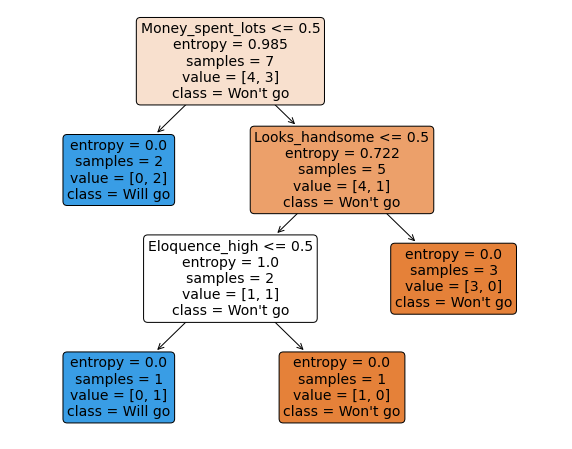

In [25]:
from sklearn.tree import plot_tree

plot_tree(clf_tree, feature_names = df_train.columns,
                   class_names=["Won't go", "Will go"],
                   filled=True, rounded=True,
                   fontsize=14);

2. Let’s split the data by the feature “Looks_handsome”. What is the entropy of the left group - the one with “Looks_handsome”. What is the entropy in the opposite group? What is the information gain (IG) if we consider such a split?

In [27]:
df_train['Looks_handsome']

0    1
1    1
2    1
3    0
4    0
5    0
6    1
Name: Looks_handsome, dtype: uint8

**S1 = -3/4 * log2(3/4) - 1/4 * log2(1/4) = 0.811**

**S2 = -1/3 * log2(1/3) - 2/3 * log2(2/3) = 0.918**

**IG = S0 - 4/7 * S1 - 3/7 * S2 = 0.128**

# Part 2. Functions for calculating entropy and information gain.

Consider the following warm-up example: we have 9 blue balls and 11 yellow balls. Let ball have label 1 if it is blue, 0 otherwise.

In [29]:
balls = [1 for i in range(9)] + [0 for i in range(11)]

In [30]:
# two groups
balls_left = [1 for i in range(8)] + [0 for i in range(5)]  # 8 blue and 5 yellow
balls_right = [1 for i in range(1)] + [0 for i in range(6)]  # 1 blue and 6 yellow

## Implement a function to calculate the Shannon Entropy

In [50]:
import math

def entropy(a_list):
    a_list = list(a_list)
    entr = 0
    for i in set(a_list): 
        num = a_list.count(i)
        entr += -num/len(a_list) * math.log2(num/len(a_list))
    return entr

3. What is the entropy of the state given by the list balls_left?

4. What is the entropy of a fair dice? (where we look at a dice as a system with 6 equally probable states)?



In [51]:
print(entropy(balls))  # 9 blue и 11 yellow
print(entropy(balls_left))  # 8 blue и 5 yellow
print(entropy(balls_right))  # 1 blue и 6 yellow
print(entropy([1, 2, 3, 4, 5, 6]))  # entropy of a fair 6-sided die

0.9927744539878083
0.9612366047228759
0.5916727785823275
2.584962500721156


5. What is the information gain from splitting the initial dataset into balls_left and balls_right ?



In [52]:
# information gain calculation
def information_gain(root, left, right):
    """ root - initial data, left and right - two partitions of initial data"""
    return (entropy(root)- (len(left) / len(root) * entropy(left))- (len(right) / len(root) * entropy(right)))

In [53]:
information_gain(balls, balls_left, balls_right)

0.16088518841412436

**Optional:**
Implement a decision tree building algorithm by calling information_gains recursively
Plot the resulting tree

In [54]:
def information_gains(X, y):
    gains = []
    for i in X.columns:
        gains.append(information_gain(y, y[X[i] == 0], y[X[i] == 1]))
    return gains

In [55]:
information_gains(df_train, y)

[0.12808527889139443,
 0.46956521111470695,
 0.46956521111470695,
 0.0059777114237740125,
 0.020244207153756077,
 0.0059777114237740125,
 0.12808527889139443,
 0.2916919971380597]

# Part 3. The “Adult” dataset

In [157]:
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/data/"

In [158]:
data_train = pd.read_csv(DATA_PATH + "adult_train.csv", sep=";")
data_train.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


In [159]:
data_test = pd.read_csv(DATA_PATH + "adult_test.csv", sep=";")
data_test.tail()


,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
16277,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K.
16278,64,NaN,321403.0,HS-grad,9.0,Widowed,NaN,Other-relative,Black,Male,0.0,0.0,40.0,United-States,<=50K.
16279,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
16280,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K.
16281,35,Self-emp-inc,182148.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,60.0,United-States,>50K.


In [160]:
# necessary to remove rows with incorrect labels in test dataset
data_test = data_test[
    (data_test["Target"] == " >50K.") | (data_test["Target"] == " <=50K.")
]

# encode target variable as integer
data_train.loc[data_train["Target"] == " <=50K", "Target"] = 0
data_train.loc[data_train["Target"] == " >50K", "Target"] = 1

data_test.loc[data_test["Target"] == " <=50K.", "Target"] = 0
data_test.loc[data_test["Target"] == " >50K.", "Target"] = 1

In [161]:
data_test.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,16281,73,35,461,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Workclass,15318,8,Private,11210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,16281.0,NaN,NaN,NaN,189435.677784,105714.907671,13492.0,116736.0,177831.0,238384.0,1490400.0
Education,16281,16,HS-grad,5283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education_Num,16281.0,NaN,NaN,NaN,10.072907,2.567545,1.0,9.0,10.0,12.0,16.0
Martial_Status,16281,7,Married-civ-spouse,7403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,15315,14,Prof-specialty,2032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relationship,16281,6,Husband,6523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Race,16281,5,White,13946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,16281,2,Male,10860,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Primary data analysis**

In [162]:
data_train["Target"].value_counts()

0    24720
1     7841
Name: Target, dtype: int64

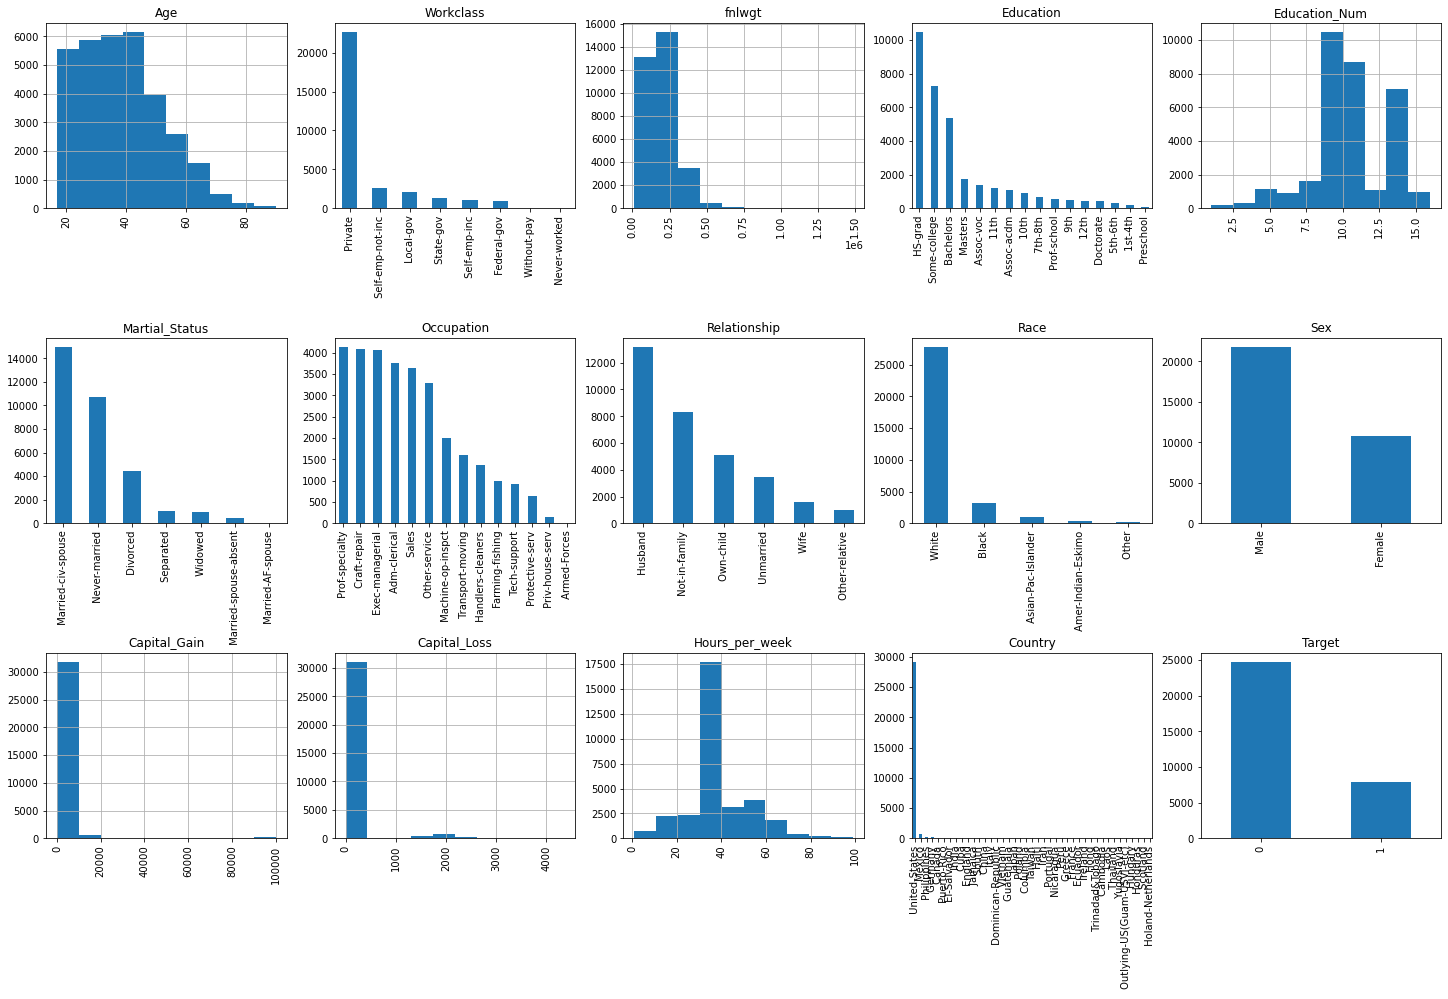

In [163]:
fig = plt.figure(figsize=(25, 15))
cols = 5
rows = int(data_train.shape[1] / cols)
for i, column in enumerate(data_train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data_train.dtypes[column] == object:
        data_train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data_train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2);

**Checking data types**

In [164]:
data_train.dtypes

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education_Num      int64
Martial_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_week     int64
Country           object
Target            object
dtype: object

In [165]:
data_test.dtypes

Age                object
Workclass          object
fnlwgt            float64
Education          object
Education_Num     float64
Martial_Status     object
Occupation         object
Relationship       object
Race               object
Sex                object
Capital_Gain      float64
Capital_Loss      float64
Hours_per_week    float64
Country            object
Target             object
dtype: object

In [166]:
data_test["Age"] = data_test["Age"].astype(int)

In [167]:
data_test["fnlwgt"] = data_test["fnlwgt"].astype(int)
data_test["Education_Num"] = data_test["Education_Num"].astype(int)
data_test["Capital_Gain"] = data_test["Capital_Gain"].astype(int)
data_test["Capital_Loss"] = data_test["Capital_Loss"].astype(int)
data_test["Hours_per_week"] = data_test["Hours_per_week"].astype(int)

In [168]:
y_train = data_train.pop('Target')
y_test = data_test.pop('Target')
y_test = y_test.astype('int')
y_train = y_train.astype('int')

**Fill in missing data for continuous features with their median values, for categorical features with their mode.**

In [169]:
# choose categorical and continuous features from data

categorical_columns = [
    c for c in data_train.columns if data_train[c].dtype.name == "object"
]
numerical_columns = [
    c for c in data_train.columns if data_train[c].dtype.name != "object"
]

print("categorical_columns:", categorical_columns)
print("numerical_columns:", numerical_columns)

categorical_columns: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country']
numerical_columns: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week']


In [170]:
# we see some missing values
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education_Num   32561 non-null  int64 
 5   Martial_Status  32561 non-null  object
 6   Occupation      30718 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital_Gain    32561 non-null  int64 
 11  Capital_Loss    32561 non-null  int64 
 12  Hours_per_week  32561 non-null  int64 
 13  Country         31978 non-null  object
dtypes: int64(6), object(8)
memory usage: 3.5+ MB


In [171]:
# fill missing data

for c in categorical_columns:
    data_train[c].fillna(data_train[c].mode()[0], inplace=True)
    data_test[c].fillna(data_train[c].mode()[0], inplace=True)

for c in numerical_columns:
    data_train[c].fillna(data_train[c].median(), inplace=True)
    data_test[c].fillna(data_train[c].median(), inplace=True)

In [172]:
# no more missing values
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education_Num   32561 non-null  int64 
 5   Martial_Status  32561 non-null  object
 6   Occupation      32561 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital_Gain    32561 non-null  int64 
 11  Capital_Loss    32561 non-null  int64 
 12  Hours_per_week  32561 non-null  int64 
 13  Country         32561 non-null  object
dtypes: int64(6), object(8)
memory usage: 3.5+ MB


In [173]:
data_train = pd.concat(
    [data_train[numerical_columns], pd.get_dummies(data_train[categorical_columns])],
    axis=1,
)

data_test = pd.concat(
    [data_test[numerical_columns], pd.get_dummies(data_test[categorical_columns])],
    axis=1,
)

In [174]:
set(data_train.columns) - set(data_test.columns)


{'Country_ Holand-Netherlands'}

In [175]:
data_train.shape, data_test.shape


((32561, 105), (16281, 104))

In [176]:
data_test["Country_ Holand-Netherlands"] = 0


In [177]:
set(data_train.columns) - set(data_test.columns)


set()

In [178]:
X_train = data_train
X_test = data_test

## 3.1 Decision tree without parameter tuning

Train a decision tree (DecisionTreeClassifier) with a maximum depth of 3, and evaluate the accuracy metric on the test data. Use parameter random_state = 17 for results reproducibility

In [179]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)

In [180]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=17)

Make a prediction with the trained model on the test data.



In [183]:
tree_predictions = tree.predict(X_test)

/Users/macbookpro/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [214]:
accuracy_score(y_test, tree_predictions)

0.8447884036607088

## 3.2 Decision tree with parameter tuning

Train a decision tree (DecisionTreeClassifier, random_state = 17). Find the optimal maximum depth using 5-fold cross-validation (GridSearchCV)

In [202]:
tree_params = {"max_depth": range(2, 11)}

locally_best_tree = GridSearchCV(estimator=tree, param_grid=tree_params, cv=5, n_jobs = -1)

locally_best_tree.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=3, random_state=17),
             n_jobs=-1, param_grid={'max_depth': range(2, 11)})

In [203]:
locally_best_tree.best_params_  

{'max_depth': 9}

In [204]:
locally_best_tree.best_score_ #best cross_val score

0.8565770273854106

In [205]:
tuned_tree = DecisionTreeClassifier(max_depth=9, random_state=17)

In [212]:
tuned_tree.fit(X_train, y_train)
tuned_tree_predictions = tuned_tree.predict(X_test)
accuracy_score(y_test, tuned_tree_predictions)

/Users/macbookpro/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


0.847798046803022

## 3.3 (Optional) Random forest without parameter tuning

Let’s take a sneak peek of upcoming lectures and try to use a random forest for our task. For now, you can imagine a random forest as a bunch of decision trees, trained on slightly different subsets of the training data.

Train a random forest (RandomForestClassifier). Set the number of trees to 100 and use random_state = 17.

In [208]:
rf = RandomForestClassifier(n_estimators=100, random_state=17)

In [209]:
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=17)

In [211]:
rf_pred = rf.predict(X_test)
accuracy_score(y_test, rf_pred)

/Users/macbookpro/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


0.8585467723112831

## 3.4 (Optional) Random forest with parameter tuning

In [215]:
forest_params = {'max_depth': range(10, 21),
                'max_features': range(5, 105, 20)}

In [216]:
loc_rf = GridSearchCV(rf, forest_params, n_jobs=-1)

loc_rf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=17), n_jobs=-1,
             param_grid={'max_depth': range(10, 21),
                         'max_features': range(5, 105, 20)})

In [ ]:
loc_rf.best_params_  

{'max_depth': 19, 'max_features': 25}

In [ ]:
loc_rf.best_estimator_

RandomForestClassifier(max_depth=19, max_features=25, random_state=17)

In [220]:
pred_rf_best = loc_rf.best_estimator_.predict(X_test)

/Users/macbookpro/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [221]:
accuracy_score(y_test,pred_rf_best)

0.8628462625145875